#Referred Material

**-Loading and transforming data **

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


-**Intro to pytorch **

https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5


-**Image preprocessing over view: **

https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258
 
 (*Try this*) https://pytorch.org/docs/stable/torchvision/transforms.html
 
 (*Try this*) https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
 
 -**List of things to try w.r.t pre-processing**
 

*   Square images + batch size 10  (**Done**)
*   Square images + bw + batch size 100 (**Done**)
*   Square images + batch size 100  (**Done**)
*   Random flips and rotation  (**Done**)
*   Five crop images + batch size 100  (**Done**)
*   Other transformation techniques  (**Done**)
*   Without normalization  (**Done**)












####Mounting the google drive for loading Dataset sand saving other files

In [68]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####Installing and loading necessary modules

In [69]:
!pip install torch
!pip install torchvision
!pip install --no-cache-dir -I pillow
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random;
import math;
import matplotlib.pyplot as plt
from skimage import io, transform
from IPython.display import clear_output, display
import torch
from torchvision import transforms, datasets
import torchvision.transforms.functional as F
from PIL import Image
import cv2
import pickle

    100% |████████████████████████████████| 2.0MB 30.2MB/s 


In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


####Loading Dataset to pandas dataframe and splitting it into train, test and validation sets

In [71]:
# with open('/content/gdrive/My Drive/Dal Masters/CSCI 6515 - ML for Big Data/Assignment 2/Data/train_corrected/train_cars.csv', 'r') as f:
#   print(f.read())  

file_dir = "/content/gdrive/My Drive/Dal Masters/CSCI 6515 - ML for Big Data/Assignment 2/Data/train_corrected/"
img_dir = file_dir + "train/"
sq_img_dir = file_dir + "train_sq/"
file_name = file_dir + "train_cars.csv"
sep_datasets = file_dir + "sep datasets/"

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df_entire_dataset = pd.read_csv(file_name)

print(df_entire_dataset.columns)
unique_car_type = df_entire_dataset.target.unique()

print(unique_car_type)

unique_car_type_dict = {}
df_entire_dataset["num_target"] = df_entire_dataset["target"]
for index, per_car_type in enumerate(unique_car_type):
  df_entire_dataset["num_target"] = df_entire_dataset["num_target"].replace(per_car_type, index)

# print(df_entire_dataset)
train_valid, test = train_test_split(df_entire_dataset, test_size=0.05, random_state =10, stratify=df_entire_dataset["num_target"])
train, valid = train_test_split(train_valid, test_size=0.05, random_state=10, stratify=train_valid["num_target"])

train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

train_data_file = sep_datasets + "train_dataset.csv"
train.to_csv(train_data_file)
valid_data_file = sep_datasets + "valid_dataset.csv"
valid.to_csv(valid_data_file)
test_data_file = sep_datasets + "test_dataset.csv"
test.to_csv(test_data_file)


print(df_entire_dataset.groupby("target").size())
# print(train.groupby("target").size())
# print(valid.groupby("target").size())
# print(test.groupby("target").size())
print(train.size)
print(valid.size)
print(test.size)


Index(['image_name', 'target'], dtype='object')
['sedan' 'truck' 'dedicated agricultural vehicle' 'jeep' 'crane truck'
 'prime mover' 'cement mixer' 'hatchback' 'minivan' 'pickup' 'van'
 'light truck' 'bus' 'tanker' 'minibus']
target
bus                                 53
cement mixer                        17
crane truck                         16
dedicated agricultural vehicle       5
hatchback                         3080
jeep                               865
light truck                        164
minibus                             25
minivan                            586
pickup                             435
prime mover                         44
sedan                             5783
tanker                               3
truck                              179
van                                362
dtype: int64
31452
1656
1743


####Class to load and transform the dataset

In [0]:
#referred from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class CarTypeDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, pd_dataframe, root_dir, transform=None, sq_image = False, image_channel = "RGB", find_edges = False):
        """
        Args:
            pd_dataframe (dataframe): Pandas dataframe with the respectve data
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cartype_frame = pd_dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.sq_image = sq_image
        self.image_channel = image_channel
        self.find_edges = find_edges

    def __len__(self):
        return len(self.cartype_frame)

    def __getitem__(self, idx):
        img_name = self.root_dir + self.cartype_frame.iloc[idx, 0]
        # read the image which returns numerical transformation of image plot using plt.imshow
        
        image = io.imread(img_name)
        actual_image = image 
        
        if self.find_edges: 
          image = cv2.Canny(image,10,100, L2gradient= True)
          
        
        pil_image = Image.fromarray(image)
        
        if self.sq_image: 
          pil_image = CarTypeDataset.make_square(pil_image)
        
#         if self.image_channel:
        pil_image = pil_image.convert(self.image_channel)

        image = pil_image
        num_car_type = self.cartype_frame.iloc[idx, 2]
        car_type = self.cartype_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': num_car_type}

        return sample


    def make_square(im, min_size=80, fill_color=(0, 0, 0, 0)):
        x, y = im.size
        min_size = x if x > y else y 
        size = max(min_size, x, y)
        new_im = Image.new('RGB', (size, size), fill_color)
        val_x = int((size - x) / 2)
        val_y = int((size - y) / 2)

        new_im.paste(im, (val_x, val_y))
        return new_im

####Calculating Mean and Standard Deviation across all the train images data

(Outputs are commented below the print statements)

In [0]:
# composed = transforms.Compose([
#         transforms.ToTensor()
#     ])


# car_type_train = CarTypeDataset(pd_dataframe=train,
#                                     root_dir=img_dir,
#                                     transform = composed)


# tensor_mean_list = []
# tensor_std_list = []

# for index in range(0,len(car_type_train)):
# #   print(str(index) + " of " + str(len(car_type_train)))
#   this_car_type = car_type_train[index]
#   this_mean = this_car_type["image"].mean(1).mean(1)
#   this_std = this_car_type["image"].std(1).std(1)
#   if index % 1000 == 0:
#     print(str(index) + " of " + str(len(car_type_train)))
    
#     print(this_mean)
#     print(this_std)
#   tensor_mean_list.append(this_mean)
#   tensor_std_list.append(this_std)
  
# tensor_mean_tuple = tuple(tensor_mean_list)
# tensor_std_tuple = tuple(tensor_std_list)

# # print(tensor_mean_tuple)

# image_means = torch.stack(tensor_mean_tuple)
# print(image_means.mean(0))
# # tensor([0.4961, 0.5154, 0.5685])

# image_std = torch.stack(tensor_std_tuple)
# print(image_std.mean(0))
# # tensor([0.0538, 0.0556, 0.0510])


####Edge Dectection Sample Code
(The sample outputs are included in the report)

In [0]:
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# from random import * 

# def plot_edges(car_type):

#   car_type_df = train.loc[train['target'] == car_type]
#   car_img = car_type_df.iloc[randint(0,len(car_type_df))]
#   image = car_img["image_name"]
#   img_name = img_dir + image
#   io_image  = io.imread(img_name)
#   print(type(io_image))

#   edges_1 = cv2.Canny(io_image,10,100, L2gradient= True)

#   plt.subplot(121),plt.imshow(edges_1)
#   plt.title('Edge Image ' + car_type), plt.xticks([]), plt.yticks([])
#   plt.subplot(122)
#   plt.imshow(io_image)
#   plt.title('Oriignal Image ' + car_type), plt.xticks([]), plt.yticks([])

#   plt.show()
  
  
# plot_edges("sedan")
# plot_edges("truck")
# plot_edges("jeep")

In [0]:
model_extra_char = "10"
num_epochs = 300;
batch_size = 1;
learning_rate = 0.001;
find_edges = False
in_kernel_size = (10,10)
hd_kernel_size = (3,3)
neuron_count = 64
max_neuron_count = int(neuron_count/4)
cnv_count = 10
full_count = 5

sq_image = False
acc_score = 0

# model_extra_char = input("Enter that extra character to apply to the best model name")
model_save_path = file_dir + "model_file_experiment_"  + str(model_extra_char) +".model"
losses_save_path = file_dir + "losses/losses_file_experiment_" + str(model_extra_char) +".csv"

resize_height = 72
resize_width = 30
rotation_degree= 10

if find_edges:
  data_transform = transforms.Compose([
          transforms.Resize((resize_height,resize_width)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(rotation_degree),
          transforms.ToTensor()

      ])
else:
  data_transform = transforms.Compose([
          transforms.Resize((resize_height,resize_width)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(rotation_degree),
          transforms.ToTensor(),
          transforms.Normalize((0.4961, 0.5154, 0.5685), (0.0538, 0.0556, 0.0510))
      ])


car_type_train_norm = CarTypeDataset(pd_dataframe=train,
                                    root_dir=img_dir,
                                    transform = data_transform, 
                                    sq_image = sq_image, 
                                    find_edges = find_edges)


dataset_loader = torch.utils.data.DataLoader(car_type_train_norm,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=12)



In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
          
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, neuron_count, kernel_size=in_kernel_size, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(neuron_count),
            nn.MaxPool2d(max_neuron_count))
  
        self.layer_hd = nn.Sequential(
            nn.Conv2d(neuron_count, neuron_count, kernel_size=hd_kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(neuron_count),
            nn.ReLU(),
            nn.MaxPool2d(max_neuron_count))

        self.fcS = nn.Linear(64, neuron_count)
        self.fc_c = nn.Linear(neuron_count, neuron_count)      
        self.fcL = nn.Linear(neuron_count, 15)
        
    def forward(self, x, cnv_count= 1, full_count = 2):
        out = self.layer1(x)     #1 
        
        for i in range(cnv_count-1):
          out = self.layer_hd(out) #2
        
        out = out.view(out.size(0), -1)
    
        out = self.fcS(out)  #First
        for i in range(full_count-2):
          out = self.fc_c(out) #1  
        out = self.fcL(out)  #Last
        return out

In [0]:
#instance of the Conv Net
cnn = CNN();
cnn.to(device)
#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

In [0]:

def valid_score(acc_score, cnn, data_transform):
  car_type_valid_norm = CarTypeDataset(pd_dataframe=valid,
                                      root_dir=img_dir,
                                      transform = data_transform,
                                       sq_image = sq_image, 
                                      find_edges = find_edges
                                      )

  valid_loader = torch.utils.data.DataLoader(car_type_valid_norm,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=8)
  cnn.eval()
  correct = 0
  total = 0
  for i, this_loader in enumerate(valid_loader):
      images = Variable(this_loader["image"].to(device))

      outputs = cnn(images, cnv_count, full_count)
      _, predicted = torch.max(outputs.data, 1)
      total += this_loader["label"].size(0)
      correct += (predicted == this_loader["label"].to(device)).sum()
    
  this_acc_score = (100 * correct / total)
  if this_acc_score > acc_score:
    acc_score = this_acc_score
    torch.save(cnn, model_save_path)
    print("Saved the model to " + model_save_path)
  print('Test Accuracy of the model on the %i test images: %.4f %%' % (len(car_type_valid_norm), (100 * correct / total)) )
  return acc_score

In [78]:
print("Size Data loader")
print(len(dataset_loader))
data_loader_len = len(dataset_loader)
losses = [];
for epoch in range(num_epochs):
    if (epoch+1) % 5 == 0:
      acc_score =  valid_score(acc_score, cnn, data_transform)
      
    for i, this_loader in enumerate(dataset_loader):
        images = Variable(this_loader["image"]).to(device)
        labels = Variable(this_loader["label"]).to(device)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images, cnv_count, full_count)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item());
        
        with open(losses_save_path, 'wb') as fp:
          pickle.dump(losses, fp)
        
        if (i+1) % int(data_loader_len/3) == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.data.item()))
          
    

Size Data loader
10484
Epoch : 1/300, Iter : 3494/10484,  Loss: 0.7528
Epoch : 1/300, Iter : 6988/10484,  Loss: 0.7701
Epoch : 1/300, Iter : 10482/10484,  Loss: 0.7363
Epoch : 2/300, Iter : 3494/10484,  Loss: 1.2585
Epoch : 2/300, Iter : 6988/10484,  Loss: 0.6575
Epoch : 2/300, Iter : 10482/10484,  Loss: 7.6675
Epoch : 3/300, Iter : 3494/10484,  Loss: 5.3659
Epoch : 3/300, Iter : 6988/10484,  Loss: 2.5362
Epoch : 3/300, Iter : 10482/10484,  Loss: 0.7685
Epoch : 4/300, Iter : 3494/10484,  Loss: 0.7051
Epoch : 4/300, Iter : 6988/10484,  Loss: 0.7589
Epoch : 4/300, Iter : 10482/10484,  Loss: 0.6749
Saved the model to /content/gdrive/My Drive/Dal Masters/CSCI 6515 - ML for Big Data/Assignment 2/Data/train_corrected/model_file_experiment_7.model
Test Accuracy of the model on the 552 test images: 49.0000 %


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch : 5/300, Iter : 3494/10484,  Loss: 2.6630
Epoch : 5/300, Iter : 6988/10484,  Loss: 0.6763
Epoch : 5/300, Iter : 10482/10484,  Loss: 0.6665
Epoch : 6/300, Iter : 3494/10484,  Loss: 0.7449
Epoch : 6/300, Iter : 6988/10484,  Loss: 0.6207
Epoch : 6/300, Iter : 10482/10484,  Loss: 1.3116
Epoch : 7/300, Iter : 3494/10484,  Loss: 0.7432
Epoch : 7/300, Iter : 6988/10484,  Loss: 0.8454
Epoch : 7/300, Iter : 10482/10484,  Loss: 1.3348
Epoch : 8/300, Iter : 3494/10484,  Loss: 3.0206
Epoch : 8/300, Iter : 6988/10484,  Loss: 3.9492
Epoch : 8/300, Iter : 10482/10484,  Loss: 2.5528
Epoch : 9/300, Iter : 3494/10484,  Loss: 3.8897
Epoch : 9/300, Iter : 6988/10484,  Loss: 0.7291
Epoch : 9/300, Iter : 10482/10484,  Loss: 0.6122
Test Accuracy of the model on the 552 test images: 49.0000 %
Epoch : 10/300, Iter : 3494/10484,  Loss: 1.2915
Epoch : 10/300, Iter : 6988/10484,  Loss: 3.4336
Epoch : 10/300, Iter : 10482/10484,  Loss: 0.6767
Epoch : 11/300, Iter : 3494/10484,  Loss: 0.6346
Epoch : 11/300, I

KeyboardInterrupt: ignored

In [0]:
# model_save_path = file_dir + "model_file_" + str(find_edges) + "_1.model"
model_save_path = file_dir + "model_file_experiment"  + str(2) +"_1.model"
torch.save(cnn, model_save_path)
print("Saved the model to " + model_save_path)

In [0]:


car_type_test = CarTypeDataset(pd_dataframe=test,
                                    root_dir=img_dir,
                                    transform = data_transform,
                                     sq_image = sq_image, 
                                    find_edges = find_edges
                                    )

test_loader = torch.utils.data.DataLoader(car_type_test,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=4)

cnn.eval()
correct = 0
total = 0
for i, this_loader in enumerate(test_loader):
    images = Variable(this_loader["image"])
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += this_loader["label"].size(0)
    correct += (predicted == this_loader["label"]).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

152658


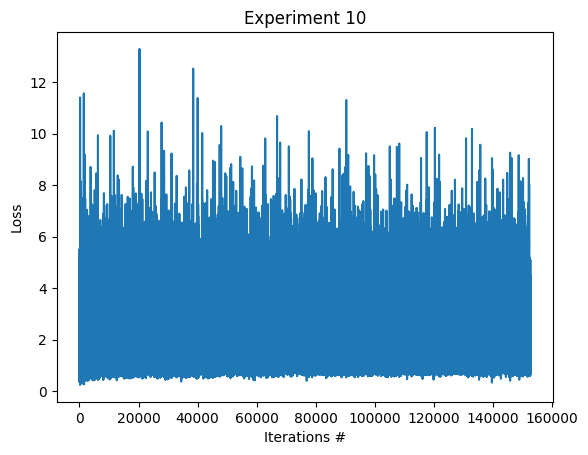

In [82]:
print(len(losses))
# losses_in_epochs = losses[0::60]
losses_in_epochs = losses
# plt.xkcd();
plt.rcdefaults()
plt.figure();
plt.title("Experiment " + str(model_extra_char))
plt.xlabel('Iterations #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();